Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.5 MB/s 
     |████████████████████████████████| 596 kB 77.5 MB/s 
     |████████████████████████████████| 6.6 MB 66.3 MB/s 
     |████████████████████████████████| 101 kB 11.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=3de3cfe4c488169973484c2a5c5378c61edf2b5f5c3dcc805d919434a6b06e29
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1KL35Y4jz-za4VhiYyi9-wDsYb-_ES9Lg'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1IdJeCCcjeLt1H8vJNgWmgTFFfSnCUfZY'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1J4zNlfBAd1ng4GfyBabBM2EGjKreruBa'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  2253
Number of dev sentences:  138
Number of test sentences:  182
Number of words in the training dataset:  5994
Number of words in the dev dataset:  1008
Number of words in the test dataset:  1171
Tags in the training dataset: ['I-Reference', 'B-Property-Type', 'I-Operation', 'B-Property-Unit', 'B-Apparatus-Unit', 'B-Material', 'I-Condition-Unit', 'B-Reference', 'B-Amount-Misc', 'I-Brand', 'I-Apparatus-Descriptor', 'I-Material', 'I-Property-Misc', 'B-Operation', 'I-Characterization-Apparatus', 'B-Meta', 'I-Apparatus-Unit', 'I-Meta', 'I-Apparatus-Property-Type', 'B-Number', 'B-Apparatus-Property-Type', 'B-Condition-Misc', 'B-Material-Descriptor', 'B-Condition-Type', 'B-Apparatus-Descriptor', 'B-Characterization-Apparatus', 'B-Nonrecipe-Material', 'B-Brand', 'B-Synthesis-Apparatus', 'I-Synthesis-Apparatus', 'I-Condition-Misc', 'I-Nonrecipe-Material', 'I-Material-Descriptor', 'I-Amount-Misc', 'B-Property-Misc', 'B-Condition-Unit', 'I-Property-Unit', 'I-Prop

,Sentence #,Word,Tag
0,Sentence: 1,10.1016,O
1,Sentence: 1,/,O
2,Sentence: 1,j.carbon.2014.03.017,O
3,Sentence: 2,High,B-Property-Misc
4,Sentence: 2,-,I-Property-Misc
5,Sentence: 2,capacity,I-Property-Misc
6,Sentence: 2,graphene,B-Material
7,Sentence: 2,oxide,I-Material
8,Sentence: 2,/,I-Material
9,Sentence: 2,graphite,I-Material


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #100 
training_sentences[100]

[('The', 'O'),
 ('obtained', 'O'),
 ('precursor', 'B-Material'),
 ('powder', 'B-Material-Descriptor'),
 ('was', 'O'),
 ('dried', 'B-Operation'),
 ('at', 'O'),
 ('120', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('and', 'O'),
 ('then', 'O'),
 ('calcined', 'B-Operation'),
 ('at', 'O'),
 ('700', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('.', 'O')]

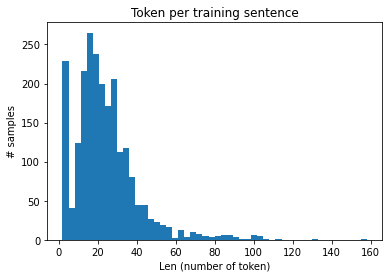

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

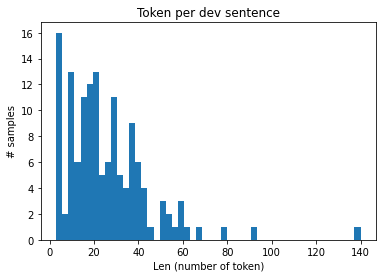

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

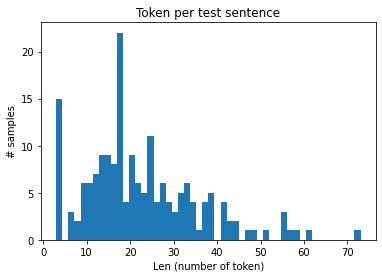

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'ethanol'
print(word2idx['ethanol'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Material'
print(tag2idx['B-Material'])
# Tag of index 4
print(idx2tag[4])

1387
2100
5
B-Apparatus-Unit


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9334)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 2253
Points in y_train before removal: 2253
Points in X_train before removal: 150
Points in y_train before removal: 150


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[3043, 6059, 5427, 6103, 3809, 125, 2919, 5547, 2152, 3687, 1558, 4805, 6059, 382, 1381, 5273, 1193, 5885, 2662, 5738, 1443, 3745, 574, 2662, 283, 1381, 2882, 2970, 2599, 4910, 5440, 667, 6405, 2160, 4961, 4072, 2853, 6157, 2323, 1558, 6426, 4961, 702]
[22, 32, 32, 5, 22, 13, 41, 5, 11, 11, 41, 5, 11, 11, 41, 41, 19, 3, 41, 1, 41, 19, 3, 41, 1, 41, 41, 19, 40, 8, 41, 25, 14, 14, 41, 41, 13, 41, 27, 41, 41, 41, 41]
[5673, 3483, 4679]
[41, 41, 41]
[5673, 3483, 2566]
[41, 41, 41]
1387
2100
5
B-Apparatus-Unit
6535
43


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 120 kB 52.6 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=27b882a092cdf4083654229ab467deb873f9b48ed0b1f4952fc65d41b7460dda
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[3043, 6059, 5427, 6103, 3809, 125, 2919, 5547, 2152, 3687, 

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8146939277648926
Training loss epoch: 1.830760153134664
Training accuracy epoch: 0.6214521184620605
Validating model...
Validation Loss: 1.068621039390564
Validation Accuracy: 0.7638664127326721
Training epoch: 2
Training loss per 100 training steps: 1.443773865699768
Training loss epoch: 0.901395046710968
Training accuracy epoch: 0.7807267093566593
Validating model...
Validation Loss: 0.82384974360466
Validation Accuracy: 0.7961209760085586
Training epoch: 3
Training loss per 100 training steps: 0.7434985637664795
Training loss epoch: 0.6050831794738769
Training accuracy epoch: 0.8438554427153301
Validating model...
Validation Loss: 0.7407741010189056
Validation Accuracy: 0.8060248363822634
Training epoch: 4
Training loss per 100 training steps: 0.6063565015792847
Training loss epoch: 0.40904083947340647
Training accuracy epoch: 0.8953366922859549
Validating model...
Validation Loss: 0.6974765598773957
Validation Accuracy: 0.81

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6826403599518996
Validation Accuracy: 0.8355484915623029
Validation duration: 0.018972700000000012 minutes
F1-score (test): 71.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.67      0.80      0.73        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.62      0.78      0.69        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.91      0.91        87
                  Material       0.65      0.87      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7686915397644043
Training loss epoch: 1.8635639150937398
Training accuracy epoch: 0.6022167006446623
Validating model...
Validation Loss: 1.2112458169460296
Validation Accuracy: 0.6920781320042834
Training epoch: 2
Training loss per 100 training steps: 1.3055213689804077
Training loss epoch: 0.9435046712557474
Training accuracy epoch: 0.7696993214324478
Validating model...
Validation Loss: 0.900648957490921
Validation Accuracy: 0.7850084028631797
Training epoch: 3
Training loss per 100 training steps: 0.6669859886169434
Training loss epoch: 0.6512366135915121
Training accuracy epoch: 0.8332082376861681
Validating model...
Validation Loss: 0.7257576584815979
Validation Accuracy: 0.8110663468413234
Training epoch: 4
Training loss per 100 training steps: 0.5992440581321716
Training loss epoch: 0.4239348848660787
Training accuracy epoch: 0.8922704304734633
Validating model...
Validation Loss: 0.6615875840187073
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6568506818551284
Validation Accuracy: 0.8329466198790667
Validation duration: 0.01903521666666658 minutes
F1-score (test): 71.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.64      0.83      0.72        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.59      0.59      0.59        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.62      0.75      0.68        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.87      0.91      0.89        87
                  Material       0.66      0.87      0.75       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.030832290649414
Training loss epoch: 1.8991545677185058
Training accuracy epoch: 0.58959019394609
Validating model...
Validation Loss: 1.1503316521644593
Validation Accuracy: 0.7445457618068104
Training epoch: 2
Training loss per 100 training steps: 1.1121883392333984
Training loss epoch: 0.9115471124649048
Training accuracy epoch: 0.7863631525999942
Validating model...
Validation Loss: 0.877080887556076
Validation Accuracy: 0.7849358896279794
Training epoch: 3
Training loss per 100 training steps: 0.6648826599121094
Training loss epoch: 0.6206441303094228
Training accuracy epoch: 0.8414377214303813
Validating model...
Validation Loss: 0.8061856150627136
Validation Accuracy: 0.7952286091192161
Training epoch: 4
Training loss per 100 training steps: 0.426382839679718
Training loss epoch: 0.4128880202770233
Training accuracy epoch: 0.8950647656427085
Validating model...
Validation Loss: 0.7544679582118988
Validation Accuracy: 0.81

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7172450285691482
Validation Accuracy: 0.8298085741261233
Validation duration: 0.016670750000000113 minutes
F1-score (test): 70.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.71      0.84      0.77        98
      Apparatus-Descriptor       0.33      0.33      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.31      0.47        13
                     Brand       0.59      0.70      0.64        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.14      1.00      0.25         1
            Condition-Unit       0.86      0.95      0.91        87
                  Material       0.64      0.88      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.046715259552002
Training loss epoch: 1.9407288908958436
Training accuracy epoch: 0.5566747538417073
Validating model...
Validation Loss: 1.2969681203365326
Validation Accuracy: 0.6788710779915033
Training epoch: 2
Training loss per 100 training steps: 0.9292438626289368
Training loss epoch: 0.9932214935620626
Training accuracy epoch: 0.7682319411303725
Validating model...
Validation Loss: 0.9425904393196106
Validation Accuracy: 0.7749862513645167
Training epoch: 3
Training loss per 100 training steps: 0.845349133014679
Training loss epoch: 0.6987013578414917
Training accuracy epoch: 0.8204156951957405
Validating model...
Validation Loss: 0.848656976222992
Validation Accuracy: 0.7911357551789177
Training epoch: 4
Training loss per 100 training steps: 0.4643217623233795
Training loss epoch: 0.48329061567783355
Training accuracy epoch: 0.8771472546587962
Validating model...
Validation Loss: 0.7518489301204682
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6894571322661179
Validation Accuracy: 0.8306925285377514
Validation duration: 0.016809649999999957 minutes
F1-score (test): 70.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.63      0.82      0.71        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.59      0.59      0.59        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.64      0.70      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.90      0.89        87
                  Material       0.63      0.85      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.822840452194214
Training loss epoch: 1.7966100295384726
Training accuracy epoch: 0.6004138518872898
Validating model...
Validation Loss: 1.1632912576198577
Validation Accuracy: 0.7258614940589094
Training epoch: 2
Training loss per 100 training steps: 1.3687281608581543
Training loss epoch: 0.9569092472394307
Training accuracy epoch: 0.7766432176305391
Validating model...
Validation Loss: 0.8898554682731629
Validation Accuracy: 0.7908822732911969
Training epoch: 3
Training loss per 100 training steps: 0.6592413783073425
Training loss epoch: 0.6729090352853139
Training accuracy epoch: 0.8299533043084203
Validating model...
Validation Loss: 0.7712748289108277
Validation Accuracy: 0.8033473563489778
Training epoch: 4
Training loss per 100 training steps: 0.3967662751674652
Training loss epoch: 0.44934682647387186
Training accuracy epoch: 0.8861167648896522
Validating model...
Validation Loss: 0.7458307147026062
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7246860701304215
Validation Accuracy: 0.8244561514145945
Validation duration: 0.016693466666666743 minutes
F1-score (test): 69.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.10      0.14      0.12         7
               Amount-Unit       0.68      0.82      0.74        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.45      0.38      0.42        13
                     Brand       0.64      0.59      0.62        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.39      0.85      0.53        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.82      0.90      0.86        87
                  Material       0.64      0.88      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8648056983947754
Training loss epoch: 1.8021415710449218
Training accuracy epoch: 0.6035825597042316
Validating model...
Validation Loss: 1.156667959690094
Validation Accuracy: 0.7075624398199347
Training epoch: 2
Training loss per 100 training steps: 1.107745885848999
Training loss epoch: 0.9304474711418151
Training accuracy epoch: 0.7651420209571344
Validating model...
Validation Loss: 0.8506875574588776
Validation Accuracy: 0.7947363828322789
Training epoch: 3
Training loss per 100 training steps: 0.7977128624916077
Training loss epoch: 0.6336174348990122
Training accuracy epoch: 0.8411029218219849
Validating model...
Validation Loss: 0.7533975303173065
Validation Accuracy: 0.8082324150669052
Training epoch: 4
Training loss per 100 training steps: 0.5266380310058594
Training loss epoch: 0.43350804448127744
Training accuracy epoch: 0.8956423355422947
Validating model...
Validation Loss: 0.700716158747673
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.64805229810568
Validation Accuracy: 0.8350942696132735
Validation duration: 0.016740216666666658 minutes
F1-score (test): 71.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.43      0.43      0.43         7
               Amount-Unit       0.70      0.82      0.75        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.55      0.67      0.60        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.67      0.90      0.77        20
            Condition-Type       0.25      1.00      0.40         1
            Condition-Unit       0.84      0.87      0.86        87
                  Material       0.63      0.80      0.71       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8647282123565674
Training loss epoch: 1.8989073991775514
Training accuracy epoch: 0.5882317395374002
Validating model...
Validation Loss: 1.2042315423488616
Validation Accuracy: 0.6929132507882245
Training epoch: 2
Training loss per 100 training steps: 1.4674197435379028
Training loss epoch: 0.9519814570744832
Training accuracy epoch: 0.7648200101291678
Validating model...
Validation Loss: 0.8794229805469513
Validation Accuracy: 0.7869002321147154
Training epoch: 3
Training loss per 100 training steps: 0.9186582565307617
Training loss epoch: 0.6490917503833771
Training accuracy epoch: 0.8362620548930034
Validating model...
Validation Loss: 0.7505783498287201
Validation Accuracy: 0.8161048371860599
Training epoch: 4
Training loss per 100 training steps: 0.3808256983757019
Training loss epoch: 0.4270759880542755
Training accuracy epoch: 0.8947261286405708
Validating model...
Validation Loss: 0.6853382825851441
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6470769529159253
Validation Accuracy: 0.8299587557138218
Validation duration: 0.016747983333332665 minutes
F1-score (test): 71.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.66      0.81      0.73        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.23      0.35        13
                     Brand       0.85      0.63      0.72        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.69      0.90      0.78        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.84      0.91      0.87        87
                  Material       0.69      0.78      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.056154251098633
Training loss epoch: 1.938006337483724
Training accuracy epoch: 0.5815722585749761
Validating model...
Validation Loss: 1.2509405136108398
Validation Accuracy: 0.6834057492756052
Training epoch: 2
Training loss per 100 training steps: 1.1799445152282715
Training loss epoch: 0.9404080192248027
Training accuracy epoch: 0.7713494943745506
Validating model...
Validation Loss: 0.8840989708900452
Validation Accuracy: 0.7921822407314095
Training epoch: 3
Training loss per 100 training steps: 0.7229610085487366
Training loss epoch: 0.6563694616158803
Training accuracy epoch: 0.8328549506806531
Validating model...
Validation Loss: 0.7614349663257599
Validation Accuracy: 0.8024008261995046
Training epoch: 4
Training loss per 100 training steps: 0.4040444791316986
Training loss epoch: 0.42500762045383456
Training accuracy epoch: 0.8919453444175117
Validating model...
Validation Loss: 0.6957448661327362
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6703930382545178
Validation Accuracy: 0.836564636019784
Validation duration: 0.016786283333333547 minutes
F1-score (test): 71.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.67      0.83      0.74        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.23      0.38        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.65      0.85      0.74        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.92      0.88        87
                  Material       0.65      0.85      0.74       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.991508722305298
Training loss epoch: 1.8583879550298055
Training accuracy epoch: 0.596186311831648
Validating model...
Validation Loss: 1.1195124387741089
Validation Accuracy: 0.7481838674793619
Training epoch: 2
Training loss per 100 training steps: 1.276551365852356
Training loss epoch: 0.8951486666997274
Training accuracy epoch: 0.7811680897070075
Validating model...
Validation Loss: 0.8547686100006103
Validation Accuracy: 0.7871415111841193
Training epoch: 3
Training loss per 100 training steps: 1.0433214902877808
Training loss epoch: 0.6052598317464193
Training accuracy epoch: 0.8513443516377227
Validating model...
Validation Loss: 0.7652418434619903
Validation Accuracy: 0.8040216640491975
Training epoch: 4
Training loss per 100 training steps: 0.5191407799720764
Training loss epoch: 0.38498628238836924
Training accuracy epoch: 0.9080065807318323
Validating model...
Validation Loss: 0.6972835391759873
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6640557234103863
Validation Accuracy: 0.8303037640858559
Validation duration: 0.01682543333333418 minutes
F1-score (test): 69.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.66      0.81      0.73        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.71      0.63      0.67        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.64      0.80      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.91      0.89        87
                  Material       0.61      0.79      0.69       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.967751979827881
Training loss epoch: 1.870065442721049
Training accuracy epoch: 0.589341136422265
Validating model...
Validation Loss: 1.189719319343567
Validation Accuracy: 0.7303830117196272
Training epoch: 2
Training loss per 100 training steps: 1.2540607452392578
Training loss epoch: 0.9433025638262431
Training accuracy epoch: 0.7833409104427084
Validating model...
Validation Loss: 0.8998038709163666
Validation Accuracy: 0.7902310872586497
Training epoch: 3
Training loss per 100 training steps: 0.8108491897583008
Training loss epoch: 0.653191328048706
Training accuracy epoch: 0.8355435445461872
Validating model...
Validation Loss: 0.7958240449428559
Validation Accuracy: 0.7984901465157318
Training epoch: 4
Training loss per 100 training steps: 0.4916689991950989
Training loss epoch: 0.43132913708686826
Training accuracy epoch: 0.8951484680005912
Validating model...
Validation Loss: 0.7344522118568421
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7136556850029872
Validation Accuracy: 0.8261473675117148
Validation duration: 0.01672751666666746 minutes
F1-score (test): 69.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.82      0.73        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.60      0.78      0.68        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.47      0.90      0.62        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.78      0.92      0.85        87
                  Material       0.66      0.85      0.74       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8774185180664062
Training loss epoch: 1.7050396015769558
Training accuracy epoch: 0.6288449899413537
Validating model...
Validation Loss: 1.0344062924385071
Validation Accuracy: 0.7626901586097115
Training epoch: 2
Training loss per 100 training steps: 0.8501520752906799
Training loss epoch: 0.7961626821442654
Training accuracy epoch: 0.8017069863614793
Validating model...
Validation Loss: 0.8289590179920197
Validation Accuracy: 0.7972804308053452
Training epoch: 3
Training loss per 100 training steps: 0.310088574886322
Training loss epoch: 0.5281648839774885
Training accuracy epoch: 0.8687277165896518
Validating model...
Validation Loss: 0.7048601120710373
Validation Accuracy: 0.8168713295455673
Training epoch: 4
Training loss per 100 training steps: 0.3193053603172302
Training loss epoch: 0.31980111802879135
Training accuracy epoch: 0.9204244832068468
Validating model...
Validation Loss: 0.6871376395225525
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6534114480018616
Validation Accuracy: 0.8398669974256804
Validation duration: 0.018847900000000094 minutes
F1-score (test): 71.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.72      0.80      0.75        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.15      0.21        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.64      0.90      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.92      0.88        87
                  Material       0.63      0.85      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9480512142181396
Training loss epoch: 1.693464799931175
Training accuracy epoch: 0.6320582934172905
Validating model...
Validation Loss: 1.0456951558589935
Validation Accuracy: 0.757851093825705
Training epoch: 2
Training loss per 100 training steps: 1.1066124439239502
Training loss epoch: 0.8582388037129453
Training accuracy epoch: 0.7872306900098959
Validating model...
Validation Loss: 0.8371362209320068
Validation Accuracy: 0.7863677549654304
Training epoch: 3
Training loss per 100 training steps: 0.673956036567688
Training loss epoch: 0.5902447716185921
Training accuracy epoch: 0.8478574153809414
Validating model...
Validation Loss: 0.7395149648189545
Validation Accuracy: 0.8107965691246701
Training epoch: 4
Training loss per 100 training steps: 0.37701892852783203
Training loss epoch: 0.4113711353979613
Training accuracy epoch: 0.8991747751982864
Validating model...
Validation Loss: 0.680583980679512
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6527418861022363
Validation Accuracy: 0.8347660197542891
Validation duration: 0.018981816666666873 minutes
F1-score (test): 72.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.72      0.81      0.76        98
      Apparatus-Descriptor       0.33      0.33      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.61      0.63      0.62        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.64      0.80      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.94      0.92        87
                  Material       0.65      0.85      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.0155463218688965
Training loss epoch: 1.7216613292694092
Training accuracy epoch: 0.626753449496181
Validating model...
Validation Loss: 1.0350839495658875
Validation Accuracy: 0.7632379279310986
Training epoch: 2
Training loss per 100 training steps: 0.987217366695404
Training loss epoch: 0.7722628791081277
Training accuracy epoch: 0.8115539866765329
Validating model...
Validation Loss: 0.8078745365142822
Validation Accuracy: 0.7990700636450071
Training epoch: 3
Training loss per 100 training steps: 0.7768860459327698
Training loss epoch: 0.5059015123467696
Training accuracy epoch: 0.8703301492646146
Validating model...
Validation Loss: 0.6854910790920258
Validation Accuracy: 0.8357764477447555
Training epoch: 4
Training loss per 100 training steps: 0.36911699175834656
Training loss epoch: 0.29922092745178624
Training accuracy epoch: 0.9279383919038628
Validating model...
Validation Loss: 0.6415652155876159
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6448086637717027
Validation Accuracy: 0.8396528263895744
Validation duration: 0.018891233333332973 minutes
F1-score (test): 70.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.83      0.74        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.67      0.90      0.77        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.85      0.98      0.91        87
                  Material       0.64      0.84      0.72       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.056424140930176
Training loss epoch: 1.7810056805610657
Training accuracy epoch: 0.6141308467121115
Validating model...
Validation Loss: 1.0775650024414063
Validation Accuracy: 0.7573028730207737
Training epoch: 2
Training loss per 100 training steps: 0.984494686126709
Training loss epoch: 0.8566071704814309
Training accuracy epoch: 0.7957341559754592
Validating model...
Validation Loss: 0.8236661553382874
Validation Accuracy: 0.7957329175664347
Training epoch: 3
Training loss per 100 training steps: 0.4825966954231262
Training loss epoch: 0.5389947452043232
Training accuracy epoch: 0.8674095595793867
Validating model...
Validation Loss: 0.7470434814691543
Validation Accuracy: 0.7998548713365004
Training epoch: 4
Training loss per 100 training steps: 0.5160573720932007
Training loss epoch: 0.3528472098865007
Training accuracy epoch: 0.9153021052907873
Validating model...
Validation Loss: 0.658072891831398
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6486593507803403
Validation Accuracy: 0.8350075934343975
Validation duration: 0.01885925000000081 minutes
F1-score (test): 71.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.72      0.85      0.78        98
      Apparatus-Descriptor       0.75      0.33      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.75      0.67      0.71        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.92      0.89        87
                  Material       0.66      0.84      0.74       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.115215301513672
Training loss epoch: 1.6496751559408087
Training accuracy epoch: 0.6293728755472932
Validating model...
Validation Loss: 1.0088008224964142
Validation Accuracy: 0.761786922661504
Training epoch: 2
Training loss per 100 training steps: 1.0063987970352173
Training loss epoch: 0.7906632893963864
Training accuracy epoch: 0.8053849031286697
Validating model...
Validation Loss: 0.8172091662883758
Validation Accuracy: 0.7947414753932801
Training epoch: 3
Training loss per 100 training steps: 0.8245482444763184
Training loss epoch: 0.49369178947649506
Training accuracy epoch: 0.8769251972944856
Validating model...
Validation Loss: 0.7105219662189484
Validation Accuracy: 0.8170955876652334
Training epoch: 4
Training loss per 100 training steps: 0.18362505733966827
Training loss epoch: 0.3200887935726266
Training accuracy epoch: 0.918579584189842
Validating model...
Validation Loss: 0.6818970799446106
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6497012789432819
Validation Accuracy: 0.8381196681750095
Validation duration: 0.018869133333333822 minutes
F1-score (test): 71.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.67      0.81      0.73        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.67      0.60      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.92      0.91        87
                  Material       0.66      0.88      0.75       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.030822277069092
Training loss epoch: 1.7177130517206693
Training accuracy epoch: 0.6268431367528797
Validating model...
Validation Loss: 1.0473019182682037
Validation Accuracy: 0.7598454388877963
Training epoch: 2
Training loss per 100 training steps: 0.7333702445030212
Training loss epoch: 0.8136233687400818
Training accuracy epoch: 0.8026432642686581
Validating model...
Validation Loss: 0.8235967099666596
Validation Accuracy: 0.7990051192073669
Training epoch: 3
Training loss per 100 training steps: 0.6802485585212708
Training loss epoch: 0.5114457764123616
Training accuracy epoch: 0.8723539112199972
Validating model...
Validation Loss: 0.7292333781719208
Validation Accuracy: 0.820198734222729
Training epoch: 4
Training loss per 100 training steps: 0.27766692638397217
Training loss epoch: 0.3130154374398683
Training accuracy epoch: 0.9222416334588998
Validating model...
Validation Loss: 0.689090245962143
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6849991793815906
Validation Accuracy: 0.8388670075282824
Validation duration: 0.020450350000000603 minutes
F1-score (test): 73.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.69      0.81      0.74        98
      Apparatus-Descriptor       0.57      0.44      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.43      0.23      0.30        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.51      0.90      0.65        20
            Condition-Type       1.00      1.00      1.00         1
            Condition-Unit       0.90      0.92      0.91        87
                  Material       0.70      0.85      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9936163425445557
Training loss epoch: 1.7144359852138318
Training accuracy epoch: 0.6193139640224142
Validating model...
Validation Loss: 1.0705388367176056
Validation Accuracy: 0.7560275455267813
Training epoch: 2
Training loss per 100 training steps: 1.1640125513076782
Training loss epoch: 0.8559589009535941
Training accuracy epoch: 0.7857284626587075
Validating model...
Validation Loss: 0.8585061967372895
Validation Accuracy: 0.785669260024158
Training epoch: 3
Training loss per 100 training steps: 0.4681876003742218
Training loss epoch: 0.5510600271977877
Training accuracy epoch: 0.8649156313841952
Validating model...
Validation Loss: 0.7394284725189209
Validation Accuracy: 0.8122803095579488
Training epoch: 4
Training loss per 100 training steps: 0.3755129277706146
Training loss epoch: 0.334481028349776
Training accuracy epoch: 0.9131393399788571
Validating model...
Validation Loss: 0.70524782538414
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7097159486550552
Validation Accuracy: 0.8227755439859622
Validation duration: 0.019073266666665253 minutes
F1-score (test): 69.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.66      0.81      0.72        98
      Apparatus-Descriptor       0.30      0.33      0.32         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.57      0.74      0.65        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.93      0.91        87
                  Material       0.60      0.90      0.72       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.366337776184082
Training loss epoch: 1.9382013772663318
Training accuracy epoch: 0.5745105090480895
Validating model...
Validation Loss: 1.2698830604553222
Validation Accuracy: 0.6791808247037249
Training epoch: 2
Training loss per 100 training steps: 1.2345777750015259
Training loss epoch: 0.9447718262672424
Training accuracy epoch: 0.7708656406096339
Validating model...
Validation Loss: 0.8844798862934112
Validation Accuracy: 0.7737965036413115
Training epoch: 3
Training loss per 100 training steps: 0.6340905427932739
Training loss epoch: 0.5988220368560991
Training accuracy epoch: 0.8481865258025112
Validating model...
Validation Loss: 0.7268915295600891
Validation Accuracy: 0.8094866356093446
Training epoch: 4
Training loss per 100 training steps: 0.4962415397167206
Training loss epoch: 0.3755879331576197
Training accuracy epoch: 0.9123673166904515
Validating model...
Validation Loss: 0.6826924026012421
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6939642291802627
Validation Accuracy: 0.8253306931884103
Validation duration: 0.02043326666666682 minutes
F1-score (test): 69.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.71      0.82      0.76        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.67      0.67      0.67        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.54      0.65      0.59        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.91      0.87        87
                  Material       0.59      0.84      0.70       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.919186592102051
Training loss epoch: 1.6921436033750836
Training accuracy epoch: 0.6368006420582297
Validating model...
Validation Loss: 1.08537957072258
Validation Accuracy: 0.7597378000133301
Training epoch: 2
Training loss per 100 training steps: 1.2225170135498047
Training loss epoch: 0.8383192074926276
Training accuracy epoch: 0.7959985694449491
Validating model...
Validation Loss: 0.789170217514038
Validation Accuracy: 0.8021313721695404
Training epoch: 3
Training loss per 100 training steps: 0.8382202386856079
Training loss epoch: 0.5246240920142123
Training accuracy epoch: 0.8628426138016493
Validating model...
Validation Loss: 0.6998647749423981
Validation Accuracy: 0.8222956655703682
Training epoch: 4
Training loss per 100 training steps: 0.39805546402931213
Training loss epoch: 0.31263805690564606
Training accuracy epoch: 0.9231818322193047
Validating model...
Validation Loss: 0.7024210095405579
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6843379942270426
Validation Accuracy: 0.8345842843585569
Validation duration: 0.018992333333333514 minutes
F1-score (test): 71.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.69      0.83      0.75        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.47      0.95      0.63        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.84      0.95      0.89        87
                  Material       0.65      0.86      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.819800853729248
Training loss epoch: 1.806315425195192
Training accuracy epoch: 0.6228012660359072
Validating model...
Validation Loss: 1.0895661890506745
Validation Accuracy: 0.7488743986599848
Training epoch: 2
Training loss per 100 training steps: 0.8215382695198059
Training loss epoch: 0.8743183267743964
Training accuracy epoch: 0.7922261159318439
Validating model...
Validation Loss: 0.8438839852809906
Validation Accuracy: 0.7877054125671897
Training epoch: 3
Training loss per 100 training steps: 0.7583773732185364
Training loss epoch: 0.57395716874223
Training accuracy epoch: 0.8542932019924265
Validating model...
Validation Loss: 0.7334500283002854
Validation Accuracy: 0.8102278599490969
Training epoch: 4
Training loss per 100 training steps: 0.5063742995262146
Training loss epoch: 0.3583590564759154
Training accuracy epoch: 0.9089889705312755
Validating model...
Validation Loss: 0.6830385059118271
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7019762717760526
Validation Accuracy: 0.8246731343953118
Validation duration: 0.01893956666666554 minutes
F1-score (test): 70.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.68      0.86      0.76        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.67      0.67      0.67        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.74      0.85      0.79        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.90      0.89        87
                  Material       0.62      0.88      0.72       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.046847820281982
Training loss epoch: 1.6237858931223552
Training accuracy epoch: 0.6453157125097836
Validating model...
Validation Loss: 0.9790582954883575
Validation Accuracy: 0.7632248872982231
Training epoch: 2
Training loss per 100 training steps: 0.8771612644195557
Training loss epoch: 0.7412563519818443
Training accuracy epoch: 0.814469401505575
Validating model...
Validation Loss: 0.7678124248981476
Validation Accuracy: 0.8074095401909187
Training epoch: 3
Training loss per 100 training steps: 0.49063044786453247
Training loss epoch: 0.4452832348289944
Training accuracy epoch: 0.8895031721223163
Validating model...
Validation Loss: 0.672211515903473
Validation Accuracy: 0.8247471888357639
Training epoch: 4
Training loss per 100 training steps: 0.39099860191345215
Training loss epoch: 0.264787668628352
Training accuracy epoch: 0.9369880117683717
Validating model...
Validation Loss: 0.6999922811985015
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6954995004030374
Validation Accuracy: 0.8220500391913744
Validation duration: 0.019030583333333576 minutes
F1-score (test): 69.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.60      0.83      0.70        98
      Apparatus-Descriptor       0.75      0.33      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.76      0.70      0.73        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.65      0.75      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.89      0.86        87
                  Material       0.64      0.87      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.778394937515259
Training loss epoch: 1.5763392675490606
Training accuracy epoch: 0.659987105813453
Validating model...
Validation Loss: 1.0122868895530701
Validation Accuracy: 0.7667947804846155
Training epoch: 2
Training loss per 100 training steps: 0.4303751289844513
Training loss epoch: 0.7706959290163857
Training accuracy epoch: 0.8058996140545334
Validating model...
Validation Loss: 0.820641940832138
Validation Accuracy: 0.7982040616339459
Training epoch: 3
Training loss per 100 training steps: 0.506229817867279
Training loss epoch: 0.4709036293483916
Training accuracy epoch: 0.8785538869782011
Validating model...
Validation Loss: 0.7170155823230744
Validation Accuracy: 0.8209042066437814
Training epoch: 4
Training loss per 100 training steps: 0.5183457732200623
Training loss epoch: 0.2940169835374469
Training accuracy epoch: 0.9295121200373228
Validating model...
Validation Loss: 0.6894156694412231
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6303791816417987
Validation Accuracy: 0.8402787734390681
Validation duration: 0.018931250000000923 minutes
F1-score (test): 72.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.14      0.18         7
               Amount-Unit       0.71      0.79      0.75        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.60      0.56      0.58        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.68      0.85      0.76        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.92      0.90        87
                  Material       0.70      0.80      0.75       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.756044626235962
Training loss epoch: 1.7059975181307112
Training accuracy epoch: 0.6318995889677399
Validating model...
Validation Loss: 1.0783780753612517
Validation Accuracy: 0.7453648070511776
Training epoch: 2
Training loss per 100 training steps: 1.044335126876831
Training loss epoch: 0.7825132693563189
Training accuracy epoch: 0.809168970007819
Validating model...
Validation Loss: 0.8095687806606293
Validation Accuracy: 0.7965132739755764
Training epoch: 3
Training loss per 100 training steps: 0.5184996128082275
Training loss epoch: 0.487637317606381
Training accuracy epoch: 0.8778592237871903
Validating model...
Validation Loss: 0.711728835105896
Validation Accuracy: 0.8223694459129967
Training epoch: 4
Training loss per 100 training steps: 0.30983883142471313
Training loss epoch: 0.28513599151656743
Training accuracy epoch: 0.9325667377106903
Validating model...
Validation Loss: 0.7023305773735047
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6935938321627103
Validation Accuracy: 0.8293760697225647
Validation duration: 0.018950766666665685 minutes
F1-score (test): 71.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.14      0.20         7
               Amount-Unit       0.67      0.81      0.73        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.50      0.80      0.62        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.86      0.97      0.91        87
                  Material       0.65      0.86      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.0964274406433105
Training loss epoch: 1.65928772517613
Training accuracy epoch: 0.6430397545700156
Validating model...
Validation Loss: 0.9972483575344085
Validation Accuracy: 0.7739222593696831
Training epoch: 2
Training loss per 100 training steps: 0.6905605792999268
Training loss epoch: 0.7203996053763798
Training accuracy epoch: 0.8225126559310849
Validating model...
Validation Loss: 0.7699714481830597
Validation Accuracy: 0.8049630759334763
Training epoch: 3
Training loss per 100 training steps: 0.47372427582740784
Training loss epoch: 0.4487281512646448
Training accuracy epoch: 0.8860930333172392
Validating model...
Validation Loss: 0.6870865046977996
Validation Accuracy: 0.8270661840705322
Training epoch: 4
Training loss per 100 training steps: 0.42153921723365784
Training loss epoch: 0.271937092145284
Training accuracy epoch: 0.9338543983744597
Validating model...
Validation Loss: 0.717944860458374
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6487329854415014
Validation Accuracy: 0.8337494185248169
Validation duration: 0.020234066666667636 minutes
F1-score (test): 70.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.62      0.87      0.73        98
      Apparatus-Descriptor       0.33      0.11      0.17         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.72      0.67      0.69        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.75      0.75      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.97      0.91        87
                  Material       0.65      0.84      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.762280225753784
Training loss epoch: 1.6189834447134108
Training accuracy epoch: 0.6501020137143904
Validating model...
Validation Loss: 0.9906283378601074
Validation Accuracy: 0.7597896327697875
Training epoch: 2
Training loss per 100 training steps: 0.6816924214363098
Training loss epoch: 0.7685570021470388
Training accuracy epoch: 0.8048280520906358
Validating model...
Validation Loss: 0.7838209688663482
Validation Accuracy: 0.801658461870263
Training epoch: 3
Training loss per 100 training steps: 0.4662359952926636
Training loss epoch: 0.48458101635887507
Training accuracy epoch: 0.8772898812094826
Validating model...
Validation Loss: 0.6698454976081848
Validation Accuracy: 0.8329434265055845
Training epoch: 4
Training loss per 100 training steps: 0.4772771894931793
Training loss epoch: 0.28872313385918025
Training accuracy epoch: 0.934134565328695
Validating model...
Validation Loss: 0.6767490565776825
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6647060284247766
Validation Accuracy: 0.8338696882783044
Validation duration: 0.019048100000001494 minutes
F1-score (test): 71.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.64      0.83      0.72        98
      Apparatus-Descriptor       0.33      0.33      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.52      0.52      0.52        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.62      0.90      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.95      0.92        87
                  Material       0.66      0.90      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8129568099975586
Training loss epoch: 1.5718261968521845
Training accuracy epoch: 0.6459019271873158
Validating model...
Validation Loss: 1.0252248167991638
Validation Accuracy: 0.7564275121182241
Training epoch: 2
Training loss per 100 training steps: 0.6878161430358887
Training loss epoch: 0.7716314821016221
Training accuracy epoch: 0.8098849235468764
Validating model...
Validation Loss: 0.8302505135536193
Validation Accuracy: 0.7944281007022072
Training epoch: 3
Training loss per 100 training steps: 0.6739294528961182
Training loss epoch: 0.515193543263844
Training accuracy epoch: 0.8615465233011358
Validating model...
Validation Loss: 0.7287075936794281
Validation Accuracy: 0.8153912169273388
Training epoch: 4
Training loss per 100 training steps: 0.513544499874115
Training loss epoch: 0.3394134498777844
Training accuracy epoch: 0.9182162259097388
Validating model...
Validation Loss: 0.6740628927946091
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6658899898712451
Validation Accuracy: 0.8334850757288701
Validation duration: 0.018907200000001012 minutes
F1-score (test): 71.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.68      0.83      0.74        98
      Apparatus-Descriptor       0.75      0.33      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.31      0.47        13
                     Brand       0.63      0.81      0.71        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.64      0.90      0.75        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.90      0.94      0.92        87
                  Material       0.63      0.87      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7865028381347656
Training loss epoch: 1.6612510737918673
Training accuracy epoch: 0.6500076295436709
Validating model...
Validation Loss: 1.0173618972301484
Validation Accuracy: 0.753200062249378
Training epoch: 2
Training loss per 100 training steps: 0.5903168320655823
Training loss epoch: 0.7764207493691218
Training accuracy epoch: 0.8026398244670012
Validating model...
Validation Loss: 0.7802167594432831
Validation Accuracy: 0.8072475754934126
Training epoch: 3
Training loss per 100 training steps: 0.555677592754364
Training loss epoch: 0.47356748580932617
Training accuracy epoch: 0.8796859710049936
Validating model...
Validation Loss: 0.6634653776884079
Validation Accuracy: 0.82681177580519
Training epoch: 4
Training loss per 100 training steps: 0.31714433431625366
Training loss epoch: 0.28429249993392397
Training accuracy epoch: 0.9339957578139988
Validating model...
Validation Loss: 0.6770221203565597
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6881789954809042
Validation Accuracy: 0.822323890052009
Validation duration: 0.018911233333335532 minutes
F1-score (test): 70.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.56      0.82      0.67        98
      Apparatus-Descriptor       0.40      0.22      0.29         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.68      0.63      0.65        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.55      0.90      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.93      0.89        87
                  Material       0.66      0.82      0.73       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.789107084274292
Training loss epoch: 1.6496813609486534
Training accuracy epoch: 0.6352424093301864
Validating model...
Validation Loss: 1.0264403998851777
Validation Accuracy: 0.7598813681019688
Training epoch: 2
Training loss per 100 training steps: 1.1974910497665405
Training loss epoch: 0.7824125715664455
Training accuracy epoch: 0.8076724560352426
Validating model...
Validation Loss: 0.7921925246715545
Validation Accuracy: 0.794086000467753
Training epoch: 3
Training loss per 100 training steps: 0.5333059430122375
Training loss epoch: 0.49415338181314017
Training accuracy epoch: 0.8723694598873761
Validating model...
Validation Loss: 0.6986706912517547
Validation Accuracy: 0.825717241943242
Training epoch: 4
Training loss per 100 training steps: 0.23885974287986755
Training loss epoch: 0.283600553160622
Training accuracy epoch: 0.9304674629141216
Validating model...
Validation Loss: 0.6785938322544098
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6788632846795596
Validation Accuracy: 0.8311342682748916
Validation duration: 0.018816033333333357 minutes
F1-score (test): 72.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.76      0.83      0.79        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.62      0.67      0.64        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.57      0.80      0.67        20
            Condition-Type       0.14      1.00      0.25         1
            Condition-Unit       0.86      0.95      0.91        87
                  Material       0.68      0.86      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.832326889038086
Training loss epoch: 1.5975202236856734
Training accuracy epoch: 0.6573337078015273
Validating model...
Validation Loss: 0.984951275587082
Validation Accuracy: 0.7678522896677322
Training epoch: 2
Training loss per 100 training steps: 0.9008253216743469
Training loss epoch: 0.7677974842843556
Training accuracy epoch: 0.8092542890275066
Validating model...
Validation Loss: 0.7639849781990051
Validation Accuracy: 0.8079095929052709
Training epoch: 3
Training loss per 100 training steps: 0.5127319693565369
Training loss epoch: 0.4821471614497049
Training accuracy epoch: 0.8747879433006327
Validating model...
Validation Loss: 0.6707976281642913
Validation Accuracy: 0.8319890778304273
Training epoch: 4
Training loss per 100 training steps: 0.47677671909332275
Training loss epoch: 0.28583407614912304
Training accuracy epoch: 0.9252622882767196
Validating model...
Validation Loss: 0.7008580207824707
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6608673127797934
Validation Accuracy: 0.8417277745806673
Validation duration: 0.01898684999999887 minutes
F1-score (test): 73.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.76      0.84      0.80        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.90      0.67        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.85      0.98      0.91        87
                  Material       0.69      0.83      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8319129943847656
Training loss epoch: 1.6085969976016454
Training accuracy epoch: 0.650580810384591
Validating model...
Validation Loss: 1.0000603675842286
Validation Accuracy: 0.7685223743673719
Training epoch: 2
Training loss per 100 training steps: 1.0008877515792847
Training loss epoch: 0.7357618524914696
Training accuracy epoch: 0.8118361393885052
Validating model...
Validation Loss: 0.7401371777057648
Validation Accuracy: 0.8182009781741268
Training epoch: 3
Training loss per 100 training steps: 0.4263482689857483
Training loss epoch: 0.4393075697478794
Training accuracy epoch: 0.8877479404719809
Validating model...
Validation Loss: 0.6947631418704987
Validation Accuracy: 0.8245212331998328
Training epoch: 4
Training loss per 100 training steps: 0.30796676874160767
Training loss epoch: 0.27854075921433313
Training accuracy epoch: 0.93393299708289
Validating model...
Validation Loss: 0.648756593465805
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6050246770565326
Validation Accuracy: 0.8449523189389706
Validation duration: 0.018892300000000736 minutes
F1-score (test): 73.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.72      0.81      0.76        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.63      0.85      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.97      0.90        87
                  Material       0.69      0.85      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.834411144256592
Training loss epoch: 1.6150182428814115
Training accuracy epoch: 0.6490571586458068
Validating model...
Validation Loss: 1.0104338586330415
Validation Accuracy: 0.7592489161117766
Training epoch: 2
Training loss per 100 training steps: 0.920264720916748
Training loss epoch: 0.7935837507247925
Training accuracy epoch: 0.8066496635845889
Validating model...
Validation Loss: 0.813303941488266
Validation Accuracy: 0.7942115205443774
Training epoch: 3
Training loss per 100 training steps: 0.5245212912559509
Training loss epoch: 0.5202572615373702
Training accuracy epoch: 0.8660298952703867
Validating model...
Validation Loss: 0.692468798160553
Validation Accuracy: 0.8276508506416291
Training epoch: 4
Training loss per 100 training steps: 0.3467037081718445
Training loss epoch: 0.33164212320532116
Training accuracy epoch: 0.9161950684408886
Validating model...
Validation Loss: 0.6770767152309418
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6614532470703125
Validation Accuracy: 0.8291094027834967
Validation duration: 0.01892726666666628 minutes
F1-score (test): 70.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.14      0.14      0.14         7
               Amount-Unit       0.69      0.82      0.75        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.52      0.75      0.61        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.95      0.92        87
                  Material       0.63      0.84      0.72       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9076855182647705
Training loss epoch: 1.5909026634125483
Training accuracy epoch: 0.6482786539685168
Validating model...
Validation Loss: 1.0506431877613067
Validation Accuracy: 0.7537111755311383
Training epoch: 2
Training loss per 100 training steps: 1.0032886266708374
Training loss epoch: 0.7423175261134193
Training accuracy epoch: 0.8158884363764726
Validating model...
Validation Loss: 0.797162190079689
Validation Accuracy: 0.797517440506064
Training epoch: 3
Training loss per 100 training steps: 0.58170086145401
Training loss epoch: 0.49729234122094657
Training accuracy epoch: 0.8762892845725284
Validating model...
Validation Loss: 0.6940308928489685
Validation Accuracy: 0.8218811272651108
Training epoch: 4
Training loss per 100 training steps: 0.4454796612262726
Training loss epoch: 0.29002700675101506
Training accuracy epoch: 0.9303789042336978
Validating model...
Validation Loss: 0.7251494705677033
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.649949883039181
Validation Accuracy: 0.8380379419798708
Validation duration: 0.01897871666666712 minutes
F1-score (test): 73.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.43      0.43      0.43         7
               Amount-Unit       0.72      0.80      0.76        98
      Apparatus-Descriptor       0.31      0.44      0.36         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.11      0.09      0.10        11
            Condition-Misc       0.58      0.75      0.65        20
            Condition-Type       0.20      1.00      0.33         1
            Condition-Unit       0.89      0.90      0.89        87
                  Material       0.70      0.87      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.9438858032226562
Training loss epoch: 1.6845928657622564
Training accuracy epoch: 0.6327129386320907
Validating model...
Validation Loss: 1.0441477715969085
Validation Accuracy: 0.7605459653186997
Training epoch: 2
Training loss per 100 training steps: 0.8548781871795654
Training loss epoch: 0.7943509646824428
Training accuracy epoch: 0.806685764930497
Validating model...
Validation Loss: 0.7971876859664917
Validation Accuracy: 0.8044385247056234
Training epoch: 3
Training loss per 100 training steps: 0.6201364994049072
Training loss epoch: 0.4878725494657244
Training accuracy epoch: 0.8760872857069253
Validating model...
Validation Loss: 0.6766324520111084
Validation Accuracy: 0.828316502282379
Training epoch: 4
Training loss per 100 training steps: 0.34734538197517395
Training loss epoch: 0.28073816817431224
Training accuracy epoch: 0.9328945043135138
Validating model...
Validation Loss: 0.6776165157556534
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6611291766166687
Validation Accuracy: 0.8293680309191817
Validation duration: 0.018813433333332342 minutes
F1-score (test): 70.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.69      0.81      0.74        98
      Apparatus-Descriptor       0.33      0.22      0.27         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.65      0.75      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.81      0.92      0.86        87
                  Material       0.65      0.81      0.72       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8870949745178223
Training loss epoch: 1.6265387194497245
Training accuracy epoch: 0.6353735727995596
Validating model...
Validation Loss: 1.023537129163742
Validation Accuracy: 0.7562438216148377
Training epoch: 2
Training loss per 100 training steps: 1.1194584369659424
Training loss epoch: 0.7884740715935117
Training accuracy epoch: 0.807165155001106
Validating model...
Validation Loss: 0.8247808158397675
Validation Accuracy: 0.7935814308797329
Training epoch: 3
Training loss per 100 training steps: 0.7075956463813782
Training loss epoch: 0.4939266840616862
Training accuracy epoch: 0.8731829507735872
Validating model...
Validation Loss: 0.7086147904396057
Validation Accuracy: 0.8218178799253385
Training epoch: 4
Training loss per 100 training steps: 0.30361708998680115
Training loss epoch: 0.29457562948976246
Training accuracy epoch: 0.9269978758680886
Validating model...
Validation Loss: 0.7850291669368744
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7132290739279527
Validation Accuracy: 0.8225529592473938
Validation duration: 0.018881783333332198 minutes
F1-score (test): 68.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.64      0.86      0.73        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.15      0.25        13
                     Brand       0.59      0.70      0.64        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.55      0.80      0.65        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.94      0.89        87
                  Material       0.59      0.86      0.70       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7377395629882812
Training loss epoch: 1.5603103637695312
Training accuracy epoch: 0.6565801563605627
Validating model...
Validation Loss: 1.0238517820835114
Validation Accuracy: 0.7636958630264462
Training epoch: 2
Training loss per 100 training steps: 1.0334137678146362
Training loss epoch: 0.7290907956305004
Training accuracy epoch: 0.8194525819240306
Validating model...
Validation Loss: 0.7870786547660827
Validation Accuracy: 0.8025128372751469
Training epoch: 3
Training loss per 100 training steps: 0.5693370699882507
Training loss epoch: 0.4341268213022323
Training accuracy epoch: 0.8954140435032103
Validating model...
Validation Loss: 0.7214070200920105
Validation Accuracy: 0.8136091585420703
Training epoch: 4
Training loss per 100 training steps: 0.33378341794013977
Training loss epoch: 0.2932741038856052
Training accuracy epoch: 0.9239891226612121
Validating model...
Validation Loss: 0.688443797826767
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7147324979305267
Validation Accuracy: 0.8227322432319807
Validation duration: 0.018910149999999248 minutes
F1-score (test): 70.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.80      0.72        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.23      0.27        13
                     Brand       0.49      0.63      0.55        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.88      0.98      0.92        87
                  Material       0.62      0.88      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.083399295806885
Training loss epoch: 1.6850775537036715
Training accuracy epoch: 0.6370439333714905
Validating model...
Validation Loss: 1.0505196750164032
Validation Accuracy: 0.7641696165408061
Training epoch: 2
Training loss per 100 training steps: 0.8051385283470154
Training loss epoch: 0.7898817871298108
Training accuracy epoch: 0.8040323717211105
Validating model...
Validation Loss: 0.7615546822547913
Validation Accuracy: 0.8134069580527141
Training epoch: 3
Training loss per 100 training steps: 0.6356155276298523
Training loss epoch: 0.5028944895381019
Training accuracy epoch: 0.8676306123283652
Validating model...
Validation Loss: 0.716022914648056
Validation Accuracy: 0.8109192723147599
Training epoch: 4
Training loss per 100 training steps: 0.33459553122520447
Training loss epoch: 0.30576909085114795
Training accuracy epoch: 0.9244286539453612
Validating model...
Validation Loss: 0.6806109070777893
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6902913863842304
Validation Accuracy: 0.8258118117716147
Validation duration: 0.018949799999999566 minutes
F1-score (test): 70.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.67      0.85      0.75        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.15      0.21        13
                     Brand       0.64      0.67      0.65        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.56      0.75      0.64        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.89      0.92      0.90        87
                  Material       0.65      0.85      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8513669967651367
Training loss epoch: 1.5517960843585787
Training accuracy epoch: 0.6660774740558002
Validating model...
Validation Loss: 1.0028234004974366
Validation Accuracy: 0.7646909877517353
Training epoch: 2
Training loss per 100 training steps: 1.1204270124435425
Training loss epoch: 0.6963712629817781
Training accuracy epoch: 0.8308874526846834
Validating model...
Validation Loss: 0.7607253968715668
Validation Accuracy: 0.8114607364950993
Training epoch: 3
Training loss per 100 training steps: 0.5532492995262146
Training loss epoch: 0.42867340005579446
Training accuracy epoch: 0.889044305364782
Validating model...
Validation Loss: 0.6818167567253113
Validation Accuracy: 0.8306809844425427
Training epoch: 4
Training loss per 100 training steps: 0.27035942673683167
Training loss epoch: 0.2432790125409762
Training accuracy epoch: 0.9405932909544938
Validating model...
Validation Loss: 0.7012429356575012
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6735298243852762
Validation Accuracy: 0.8349647885012016
Validation duration: 0.018973816666664332 minutes
F1-score (test): 71.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.85      0.72        98
      Apparatus-Descriptor       0.57      0.44      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.08      0.13        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.94      0.89        87
                  Material       0.67      0.87      0.75       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.629486083984375
Training loss epoch: 1.558873976979937
Training accuracy epoch: 0.6553962999335224
Validating model...
Validation Loss: 1.0096602082252502
Validation Accuracy: 0.7675980427790654
Training epoch: 2
Training loss per 100 training steps: 1.0020241737365723
Training loss epoch: 0.7631543988273257
Training accuracy epoch: 0.8074337640821182
Validating model...
Validation Loss: 0.7760680377483368
Validation Accuracy: 0.7996240082617718
Training epoch: 3
Training loss per 100 training steps: 0.4056529998779297
Training loss epoch: 0.48190936304274057
Training accuracy epoch: 0.868833644875447
Validating model...
Validation Loss: 0.6688531577587128
Validation Accuracy: 0.8298813104454519
Training epoch: 4
Training loss per 100 training steps: 0.29964789748191833
Training loss epoch: 0.2729518832195373
Training accuracy epoch: 0.9306378551876355
Validating model...
Validation Loss: 0.6302767336368561
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.655423817726282
Validation Accuracy: 0.8314995330244683
Validation duration: 0.019182699999998932 minutes
F1-score (test): 70.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.69      0.84      0.76        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.23      0.33        13
                     Brand       0.62      0.89      0.73        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.70      0.95      0.81        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.93      0.90        87
                  Material       0.66      0.83      0.73       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.009523391723633
Training loss epoch: 1.6192547111284166
Training accuracy epoch: 0.6449291920872536
Validating model...
Validation Loss: 0.9717553794384003
Validation Accuracy: 0.7690449914522632
Training epoch: 2
Training loss per 100 training steps: 0.9104302525520325
Training loss epoch: 0.7594190864335923
Training accuracy epoch: 0.8100985861998747
Validating model...
Validation Loss: 0.7410695135593415
Validation Accuracy: 0.8138515715217516
Training epoch: 3
Training loss per 100 training steps: 0.4184706211090088
Training loss epoch: 0.45725939245451064
Training accuracy epoch: 0.8882921989399548
Validating model...
Validation Loss: 0.6710018754005432
Validation Accuracy: 0.8278787715771869
Training epoch: 4
Training loss per 100 training steps: 0.22990825772285461
Training loss epoch: 0.24583883228756132
Training accuracy epoch: 0.9395580723383901
Validating model...
Validation Loss: 0.7329132616519928
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6889452842565683
Validation Accuracy: 0.8230357272590377
Validation duration: 0.019514766666668494 minutes
F1-score (test): 69.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.61      0.81      0.69        98
      Apparatus-Descriptor       0.75      0.33      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.68      0.85      0.75        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.48      0.80      0.60        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.79      0.93      0.85        87
                  Material       0.63      0.88      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8934836387634277
Training loss epoch: 1.6724565909022377
Training accuracy epoch: 0.6342576947684145
Validating model...
Validation Loss: 1.07003333568573
Validation Accuracy: 0.758768867290442
Training epoch: 2
Training loss per 100 training steps: 0.974931001663208
Training loss epoch: 0.7971106143224806
Training accuracy epoch: 0.8049861445404128
Validating model...
Validation Loss: 0.8572551727294921
Validation Accuracy: 0.7902570186034618
Training epoch: 3
Training loss per 100 training steps: 0.6287546753883362
Training loss epoch: 0.5330797150021508
Training accuracy epoch: 0.8645742366694132
Validating model...
Validation Loss: 0.7558378577232361
Validation Accuracy: 0.8095983886330907
Training epoch: 4
Training loss per 100 training steps: 0.37137165665626526
Training loss epoch: 0.33280996907325017
Training accuracy epoch: 0.9152214843689487
Validating model...
Validation Loss: 0.6908611476421356
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7248325875172248
Validation Accuracy: 0.8182678592723746
Validation duration: 0.019028883333332185 minutes
F1-score (test): 68.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.14      0.17         7
               Amount-Unit       0.66      0.84      0.74        98
      Apparatus-Descriptor       0.75      0.33      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.00      0.00      0.00        13
                     Brand       0.50      0.48      0.49        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.57      0.80      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.83      0.94      0.88        87
                  Material       0.61      0.87      0.71       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.169878959655762
Training loss epoch: 1.7027430832386017
Training accuracy epoch: 0.6311269304526411
Validating model...
Validation Loss: 1.0581588685512542
Validation Accuracy: 0.7473322884769079
Training epoch: 2
Training loss per 100 training steps: 0.736853301525116
Training loss epoch: 0.7439484342932701
Training accuracy epoch: 0.8202846701931069
Validating model...
Validation Loss: 0.8015150725841522
Validation Accuracy: 0.8032102692174243
Training epoch: 3
Training loss per 100 training steps: 0.4503624439239502
Training loss epoch: 0.437913154065609
Training accuracy epoch: 0.894058862761908
Validating model...
Validation Loss: 0.6912265241146087
Validation Accuracy: 0.8192389419220648
Training epoch: 4
Training loss per 100 training steps: 0.2760081887245178
Training loss epoch: 0.260180976241827
Training accuracy epoch: 0.9390165236738495
Validating model...
Validation Loss: 0.7213191300630569
Validation Accuracy: 0.81

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6550519168376923
Validation Accuracy: 0.8318146308075713
Validation duration: 0.019750433333335118 minutes
F1-score (test): 69.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.60      0.80      0.68        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.08      0.12        13
                     Brand       0.64      0.67      0.65        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.68      0.75      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.87      0.86        87
                  Material       0.68      0.82      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.1311564445495605
Training loss epoch: 1.6953828454017639
Training accuracy epoch: 0.6322819337513852
Validating model...
Validation Loss: 1.0016702592372895
Validation Accuracy: 0.7694562902590703
Training epoch: 2
Training loss per 100 training steps: 0.8785787224769592
Training loss epoch: 0.7373301088809967
Training accuracy epoch: 0.8125779512664778
Validating model...
Validation Loss: 0.7907037079334259
Validation Accuracy: 0.8009222358826851
Training epoch: 3
Training loss per 100 training steps: 0.7256736159324646
Training loss epoch: 0.4571481093764305
Training accuracy epoch: 0.8828031663522384
Validating model...
Validation Loss: 0.6975374817848206
Validation Accuracy: 0.8189505998219155
Training epoch: 4
Training loss per 100 training steps: 0.21028916537761688
Training loss epoch: 0.26612311899662017
Training accuracy epoch: 0.9356312788605109
Validating model...
Validation Loss: 0.6663154900074005
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6746337207464072
Validation Accuracy: 0.8347630221493996
Validation duration: 0.02108375000000251 minutes
F1-score (test): 72.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.77      0.92      0.84        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.52      0.80      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.93      0.91        87
                  Material       0.65      0.89      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8789520263671875
Training loss epoch: 1.659348276257515
Training accuracy epoch: 0.635263340059911
Validating model...
Validation Loss: 1.036068081855774
Validation Accuracy: 0.7689748638694514
Training epoch: 2
Training loss per 100 training steps: 1.1336596012115479
Training loss epoch: 0.7564301520586014
Training accuracy epoch: 0.814956973787164
Validating model...
Validation Loss: 0.7951214075088501
Validation Accuracy: 0.7927102090332104
Training epoch: 3
Training loss per 100 training steps: 0.6225032210350037
Training loss epoch: 0.45185327231884004
Training accuracy epoch: 0.8905395854355905
Validating model...
Validation Loss: 0.694161233305931
Validation Accuracy: 0.8210643840708018
Training epoch: 4
Training loss per 100 training steps: 0.3095798194408417
Training loss epoch: 0.2545980714261532
Training accuracy epoch: 0.9418488081943488
Validating model...
Validation Loss: 0.6872988641262054
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.674411402298854
Validation Accuracy: 0.8300281801587412
Validation duration: 0.019810216666667203 minutes
F1-score (test): 70.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.68      0.78      0.73        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.66      0.85      0.74        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.90      0.67        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.65      0.79      0.72       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.80873966217041
Training loss epoch: 1.5339197486639022
Training accuracy epoch: 0.6651105962667447
Validating model...
Validation Loss: 1.0080859005451202
Validation Accuracy: 0.7603167097148715
Training epoch: 2
Training loss per 100 training steps: 0.7110975384712219
Training loss epoch: 0.7104187130928039
Training accuracy epoch: 0.8204216705163818
Validating model...
Validation Loss: 0.7582198858261109
Validation Accuracy: 0.8078237394703518
Training epoch: 3
Training loss per 100 training steps: 0.40288540720939636
Training loss epoch: 0.41762357354164126
Training accuracy epoch: 0.8918475003825405
Validating model...
Validation Loss: 0.6511573404073715
Validation Accuracy: 0.8358838597278411
Training epoch: 4
Training loss per 100 training steps: 0.27031004428863525
Training loss epoch: 0.23479269742965697
Training accuracy epoch: 0.9459699076201135
Validating model...
Validation Loss: 0.6840524435043335
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6923676912601178
Validation Accuracy: 0.8256145433203225
Validation duration: 0.021285583333334065 minutes
F1-score (test): 69.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.71      0.86      0.77        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.08      0.12        13
                     Brand       0.69      0.67      0.68        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.64      0.80      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.98      0.92        87
                  Material       0.63      0.80      0.71       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.957181930541992
Training loss epoch: 1.708721935749054
Training accuracy epoch: 0.6303692741548994
Validating model...
Validation Loss: 1.0346844792366028
Validation Accuracy: 0.7627698154638993
Training epoch: 2
Training loss per 100 training steps: 0.6852893829345703
Training loss epoch: 0.7745596885681152
Training accuracy epoch: 0.8084526603527744
Validating model...
Validation Loss: 0.8055160939693451
Validation Accuracy: 0.8030565302785984
Training epoch: 3
Training loss per 100 training steps: 0.586940586566925
Training loss epoch: 0.4698680713772774
Training accuracy epoch: 0.8839624364845646
Validating model...
Validation Loss: 0.7121739149093628
Validation Accuracy: 0.8199989154696755
Training epoch: 4
Training loss per 100 training steps: 0.30889058113098145
Training loss epoch: 0.26586933210492136
Training accuracy epoch: 0.9323479111116486
Validating model...
Validation Loss: 0.7036613374948502
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7128992814284104
Validation Accuracy: 0.8361172716992454
Validation duration: 0.019829733333328173 minutes
F1-score (test): 72.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.14      0.14      0.14         7
               Amount-Unit       0.76      0.89      0.82        98
      Apparatus-Descriptor       0.57      0.44      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.73      0.70      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.50      0.90      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.69      0.88      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.780951976776123
Training loss epoch: 1.6248067557811736
Training accuracy epoch: 0.6398266990640863
Validating model...
Validation Loss: 1.0340297520160675
Validation Accuracy: 0.7622414786130777
Training epoch: 2
Training loss per 100 training steps: 0.9003256559371948
Training loss epoch: 0.7987327307462693
Training accuracy epoch: 0.8013427573645522
Validating model...
Validation Loss: 0.8104368448257446
Validation Accuracy: 0.7991086468308072
Training epoch: 3
Training loss per 100 training steps: 0.38310733437538147
Training loss epoch: 0.5025088131427765
Training accuracy epoch: 0.8678317092670106
Validating model...
Validation Loss: 0.677668571472168
Validation Accuracy: 0.8261426084282675
Training epoch: 4
Training loss per 100 training steps: 0.28009548783302307
Training loss epoch: 0.2855399541556835
Training accuracy epoch: 0.9306642903444338
Validating model...
Validation Loss: 0.6389140605926513
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6481612897836245
Validation Accuracy: 0.8343149187659141
Validation duration: 0.019825600000005276 minutes
F1-score (test): 71.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.72      0.85      0.78        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.15      0.21        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.46      0.80      0.58        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.94      0.90        87
                  Material       0.66      0.87      0.75       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.916961908340454
Training loss epoch: 1.6223058253526688
Training accuracy epoch: 0.6493371114387555
Validating model...
Validation Loss: 1.0114298522472382
Validation Accuracy: 0.7731238596233199
Training epoch: 2
Training loss per 100 training steps: 0.9708306193351746
Training loss epoch: 0.7842041224241256
Training accuracy epoch: 0.8054481053070279
Validating model...
Validation Loss: 0.7842936098575592
Validation Accuracy: 0.8164108841778643
Training epoch: 3
Training loss per 100 training steps: 0.6284872889518738
Training loss epoch: 0.46169637590646745
Training accuracy epoch: 0.8817463886692417
Validating model...
Validation Loss: 0.7112133473157882
Validation Accuracy: 0.8212995963171498
Training epoch: 4
Training loss per 100 training steps: 0.4698893129825592
Training loss epoch: 0.27410646229982377
Training accuracy epoch: 0.9352458520510739
Validating model...
Validation Loss: 0.7081134676933288
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6955697238445282
Validation Accuracy: 0.8274954760112986
Validation duration: 0.01978148333333441 minutes
F1-score (test): 70.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.68      0.81      0.73        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.68      0.70      0.69        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.56      0.90      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.82      0.92      0.87        87
                  Material       0.66      0.87      0.75       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.053890228271484
Training loss epoch: 1.7034212231636048
Training accuracy epoch: 0.6304010092231753
Validating model...
Validation Loss: 1.0705715835094451
Validation Accuracy: 0.7542923081685223
Training epoch: 2
Training loss per 100 training steps: 0.986401379108429
Training loss epoch: 0.793811583518982
Training accuracy epoch: 0.8091993466503782
Validating model...
Validation Loss: 0.8212964236736298
Validation Accuracy: 0.7902972177954914
Training epoch: 3
Training loss per 100 training steps: 0.5364128351211548
Training loss epoch: 0.506489384174347
Training accuracy epoch: 0.8684489566755567
Validating model...
Validation Loss: 0.7279657304286957
Validation Accuracy: 0.8169968224103406
Training epoch: 4
Training loss per 100 training steps: 0.3197943866252899
Training loss epoch: 0.30828136689960955
Training accuracy epoch: 0.9242746419927228
Validating model...
Validation Loss: 0.7011447578668595
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6943755654188303
Validation Accuracy: 0.8311181543811617
Validation duration: 0.019776183333328846 minutes
F1-score (test): 70.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.40      0.29      0.33         7
               Amount-Unit       0.67      0.83      0.74        98
      Apparatus-Descriptor       0.36      0.44      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.61      0.70      0.66        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.46      0.80      0.58        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.84      0.85        87
                  Material       0.66      0.82      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda
Training epoch: 1
Training loss per 100 training steps: 3.9590117931365967
Training loss epoch: 1.6281656920909882
Training accuracy epoch: 0.6426484347676967
Validating model...
Validation Loss: 1.0452524840831756
Validation Accuracy: 0.7567372142039288
Training epoch: 2
Training loss per 100 training steps: 1.1458570957183838
Training loss epoch: 0.7620801210403443
Training accuracy epoch: 0.8066378637998914
Validating model...
Validation Loss: 0.7720693945884705
Validation Accuracy: 0.8127771057465202
Training epoch: 3
Training loss per 100 training steps: 0.5644329190254211
Training loss epoch: 0.45871383398771287
Training accuracy epoch: 0.8841683006390502
Validating model...
Validation Loss: 0.7250244230031967
Validation Accuracy: 0.8125450170359653
Training epoch: 4
Training loss per 100 training steps: 0.3029721975326538
Training loss epoch: 0.2599408760666847
Training accuracy epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6963674265604752
Validation Accuracy: 0.8300269716239913
Validation duration: 0.019792083333330386 minutes
F1-score (test): 71.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.68      0.83      0.75        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.81      0.78      0.79        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.71      0.85      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.93      0.89        87
                  Material       0.66      0.85      0.75       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.02578592300415
Training loss epoch: 1.769292801618576
Training accuracy epoch: 0.6188583156624186
Validating model...
Validation Loss: 1.0802657067775727
Validation Accuracy: 0.7599387566533342
Training epoch: 2
Training loss per 100 training steps: 0.8278138637542725
Training loss epoch: 0.7924762904644013
Training accuracy epoch: 0.8100912692241913
Validating model...
Validation Loss: 0.8118024826049804
Validation Accuracy: 0.7989077612256844
Training epoch: 3
Training loss per 100 training steps: 0.5705240368843079
Training loss epoch: 0.47389097064733504
Training accuracy epoch: 0.8864586178246115
Validating model...
Validation Loss: 0.7238645434379578
Validation Accuracy: 0.8201850319796478
Training epoch: 4
Training loss per 100 training steps: 0.23471587896347046
Training loss epoch: 0.27037891298532485
Training accuracy epoch: 0.9362451963503517
Validating model...
Validation Loss: 0.7010588824748993
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7109579627330487
Validation Accuracy: 0.825498827014705
Validation duration: 0.019725583333335333 minutes
F1-score (test): 69.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.60      0.81      0.69        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.23      0.32        13
                     Brand       0.62      0.74      0.68        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.66      0.95      0.78        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.97      0.90        87
                  Material       0.64      0.85      0.73       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7545740604400635
Training loss epoch: 1.5054657345726377
Training accuracy epoch: 0.6629294084324221
Validating model...
Validation Loss: 0.9959360003471375
Validation Accuracy: 0.7725120756430723
Training epoch: 2
Training loss per 100 training steps: 0.8804153203964233
Training loss epoch: 0.6738027958642869
Training accuracy epoch: 0.8335271968600424
Validating model...
Validation Loss: 0.7708983242511749
Validation Accuracy: 0.8022996518630487
Training epoch: 3
Training loss per 100 training steps: 0.42581474781036377
Training loss epoch: 0.3783053911867596
Training accuracy epoch: 0.903303840111686
Validating model...
Validation Loss: 0.6906657636165618
Validation Accuracy: 0.8234132174527378
Training epoch: 4
Training loss per 100 training steps: 0.21918776631355286
Training loss epoch: 0.20672202642474855
Training accuracy epoch: 0.9508253921582964
Validating model...
Validation Loss: 0.6972126424312591
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7120966269419744
Validation Accuracy: 0.8217537005650916
Validation duration: 0.019756766666667622 minutes
F1-score (test): 68.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.63      0.83      0.71        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.55      0.59      0.57        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.19      0.30      0.23        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.75      0.94      0.84        87
                  Material       0.64      0.86      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.717989206314087
Training loss epoch: 1.5704519578388758
Training accuracy epoch: 0.6585169577154323
Validating model...
Validation Loss: 1.002648162841797
Validation Accuracy: 0.7661165180472249
Training epoch: 2
Training loss per 100 training steps: 0.7534058690071106
Training loss epoch: 0.7084542711575826
Training accuracy epoch: 0.8251050856820938
Validating model...
Validation Loss: 0.7817676424980163
Validation Accuracy: 0.8143471211910491
Training epoch: 3
Training loss per 100 training steps: 0.6104539036750793
Training loss epoch: 0.4036206432751247
Training accuracy epoch: 0.8996685539221745
Validating model...
Validation Loss: 0.7128990173339844
Validation Accuracy: 0.8304690560280035
Training epoch: 4
Training loss per 100 training steps: 0.16261766850948334
Training loss epoch: 0.21877844560713994
Training accuracy epoch: 0.9478677821066877
Validating model...
Validation Loss: 0.7543272197246551
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6786305193717663
Validation Accuracy: 0.8363008035031044
Validation duration: 0.019922950000000127 minutes
F1-score (test): 70.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.70      0.82      0.75        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.15      0.27        13
                     Brand       0.61      0.63      0.62        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.50      0.65      0.57        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.99      0.91        87
                  Material       0.65      0.83      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.898061752319336
Training loss epoch: 1.5481560883067904
Training accuracy epoch: 0.6613841940247452
Validating model...
Validation Loss: 0.9845109105110168
Validation Accuracy: 0.7720437407613533
Training epoch: 2
Training loss per 100 training steps: 0.8024580478668213
Training loss epoch: 0.6813148771013532
Training accuracy epoch: 0.8325158067000583
Validating model...
Validation Loss: 0.739030408859253
Validation Accuracy: 0.8151308210937461
Training epoch: 3
Training loss per 100 training steps: 0.5599071383476257
Training loss epoch: 0.4027209147101357
Training accuracy epoch: 0.8968802739196516
Validating model...
Validation Loss: 0.6792100369930267
Validation Accuracy: 0.8266668032198112
Training epoch: 4
Training loss per 100 training steps: 0.2709965705871582
Training loss epoch: 0.23639146841707684
Training accuracy epoch: 0.9407347397370581
Validating model...
Validation Loss: 0.6666336774826049
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6648317850553073
Validation Accuracy: 0.8369723072773739
Validation duration: 0.019811833333331683 minutes
F1-score (test): 71.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.74      0.84      0.78        98
      Apparatus-Descriptor       0.36      0.44      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.36      0.31      0.33        13
                     Brand       0.75      0.78      0.76        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.47      0.75      0.58        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.86      0.95      0.90        87
                  Material       0.69      0.84      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.979691743850708
Training loss epoch: 1.501949965953827
Training accuracy epoch: 0.674888972143653
Validating model...
Validation Loss: 1.0065661728382111
Validation Accuracy: 0.7563840187718064
Training epoch: 2
Training loss per 100 training steps: 0.8471025228500366
Training loss epoch: 0.6521064383643014
Training accuracy epoch: 0.839258305013548
Validating model...
Validation Loss: 0.7816213548183442
Validation Accuracy: 0.802200596318916
Training epoch: 3
Training loss per 100 training steps: 0.41770312190055847
Training loss epoch: 0.3784124134551911
Training accuracy epoch: 0.9050088475493813
Validating model...
Validation Loss: 0.7122380614280701
Validation Accuracy: 0.8176454254737562
Training epoch: 4
Training loss per 100 training steps: 0.2432377189397812
Training loss epoch: 0.22516848359789168
Training accuracy epoch: 0.9428494754946354
Validating model...
Validation Loss: 0.7073528975248337
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7052944623506986
Validation Accuracy: 0.8334170175181607
Validation duration: 0.019927183333334143 minutes
F1-score (test): 72.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.75      0.88      0.81        98
      Apparatus-Descriptor       0.50      0.44      0.47         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.61      0.81      0.70        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.46      0.80      0.58        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.86      0.98      0.91        87
                  Material       0.71      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8416593074798584
Training loss epoch: 1.4990294916289193
Training accuracy epoch: 0.6723402014628497
Validating model...
Validation Loss: 0.9774783611297607
Validation Accuracy: 0.7736556005146965
Training epoch: 2
Training loss per 100 training steps: 0.8007850050926208
Training loss epoch: 0.6868455041022528
Training accuracy epoch: 0.8272733869817105
Validating model...
Validation Loss: 0.7770332098007202
Validation Accuracy: 0.8027145847773461
Training epoch: 3
Training loss per 100 training steps: 0.4317018389701843
Training loss epoch: 0.38367993632952374
Training accuracy epoch: 0.9017799683166702
Validating model...
Validation Loss: 0.7119722604751587
Validation Accuracy: 0.8217390827125352
Training epoch: 4
Training loss per 100 training steps: 0.2539292573928833
Training loss epoch: 0.21239134527388073
Training accuracy epoch: 0.9482176302563875
Validating model...
Validation Loss: 0.6868117094039917
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6669431374623225
Validation Accuracy: 0.8390054520219531
Validation duration: 0.019809066666660633 minutes
F1-score (test): 72.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.73      0.84      0.78        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.68      0.85      0.75        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.67      0.90      0.77        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.85      0.98      0.91        87
                  Material       0.67      0.85      0.75       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.969268560409546
Training loss epoch: 1.4430839816729228
Training accuracy epoch: 0.6790163152523102
Validating model...
Validation Loss: 0.968319833278656
Validation Accuracy: 0.7703958292336484
Training epoch: 2
Training loss per 100 training steps: 0.6671099066734314
Training loss epoch: 0.5792734821637472
Training accuracy epoch: 0.854809917334592
Validating model...
Validation Loss: 0.7271620154380798
Validation Accuracy: 0.8214162640639397
Training epoch: 3
Training loss per 100 training steps: 0.3032858073711395
Training loss epoch: 0.30989677494480494
Training accuracy epoch: 0.9230309883989801
Validating model...
Validation Loss: 0.6925276607275009
Validation Accuracy: 0.8319709878020136
Training epoch: 4
Training loss per 100 training steps: 0.22240282595157623
Training loss epoch: 0.1755997542114485
Training accuracy epoch: 0.9580084173691019
Validating model...
Validation Loss: 0.7022007882595063
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.720290312400231
Validation Accuracy: 0.8245833013782019
Validation duration: 0.019678383333333233 minutes
F1-score (test): 69.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.66      0.82      0.73        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.44      0.31      0.36        13
                     Brand       0.38      0.44      0.41        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.46      0.90      0.61        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.88      0.95      0.92        87
                  Material       0.67      0.87      0.75       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.011959075927734
Training loss epoch: 1.5872865035420372
Training accuracy epoch: 0.6486949904796897
Validating model...
Validation Loss: 0.9882161855697632
Validation Accuracy: 0.7656860927641562
Training epoch: 2
Training loss per 100 training steps: 0.7518244981765747
Training loss epoch: 0.6830202114014399
Training accuracy epoch: 0.8335022534073634
Validating model...
Validation Loss: 0.7926380634307861
Validation Accuracy: 0.8057116641061667
Training epoch: 3
Training loss per 100 training steps: 0.46335265040397644
Training loss epoch: 0.38433321600868586
Training accuracy epoch: 0.9081791545283929
Validating model...
Validation Loss: 0.7010441929101944
Validation Accuracy: 0.8327446147545391
Training epoch: 4
Training loss per 100 training steps: 0.3004876673221588
Training loss epoch: 0.2100151273466292
Training accuracy epoch: 0.9501867765293732
Validating model...
Validation Loss: 0.7139512538909912
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6937757226137015
Validation Accuracy: 0.8285322678647836
Validation duration: 0.01970774999999776 minutes
F1-score (test): 69.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.61      0.84      0.71        98
      Apparatus-Descriptor       0.75      0.33      0.46         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.72      0.67      0.69        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.50      0.65      0.57        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.94      0.91        87
                  Material       0.63      0.85      0.72       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.766706943511963
Training loss epoch: 1.471903023265657
Training accuracy epoch: 0.6726409773977928
Validating model...
Validation Loss: 0.9502665758132934
Validation Accuracy: 0.7709582084665146
Training epoch: 2
Training loss per 100 training steps: 0.792443573474884
Training loss epoch: 0.6361268957455953
Training accuracy epoch: 0.8378557314263534
Validating model...
Validation Loss: 0.7823454320430756
Validation Accuracy: 0.7956015743603008
Training epoch: 3
Training loss per 100 training steps: 0.4041692316532135
Training loss epoch: 0.3643860086089089
Training accuracy epoch: 0.9082091697767852
Validating model...
Validation Loss: 0.707164192199707
Validation Accuracy: 0.8239626806388698
Training epoch: 4
Training loss per 100 training steps: 0.31456032395362854
Training loss epoch: 0.19769699161960966
Training accuracy epoch: 0.9540609320782966
Validating model...
Validation Loss: 0.6813339084386826
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6941260833006638
Validation Accuracy: 0.8297316536995974
Validation duration: 0.019691383333330727 minutes
F1-score (test): 70.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.69      0.84      0.76        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.15      0.21        13
                     Brand       0.61      0.74      0.67        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.50      1.00      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.95      0.94        87
                  Material       0.68      0.79      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9377219676971436
Training loss epoch: 1.5888349839619227
Training accuracy epoch: 0.6463016121022324
Validating model...
Validation Loss: 1.0182490825653077
Validation Accuracy: 0.7690705489826988
Training epoch: 2
Training loss per 100 training steps: 0.7604372501373291
Training loss epoch: 0.7355025779633295
Training accuracy epoch: 0.8218477238122048
Validating model...
Validation Loss: 0.813114482164383
Validation Accuracy: 0.8002942502582501
Training epoch: 3
Training loss per 100 training steps: 0.5734705924987793
Training loss epoch: 0.4277577286674863
Training accuracy epoch: 0.888809417591873
Validating model...
Validation Loss: 0.721217292547226
Validation Accuracy: 0.821468332052269
Training epoch: 4
Training loss per 100 training steps: 0.2625431716442108
Training loss epoch: 0.23926504027275813
Training accuracy epoch: 0.9395665399607135
Validating model...
Validation Loss: 0.6938912093639373
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7067565046823941
Validation Accuracy: 0.8348090821170044
Validation duration: 0.019640466666661874 minutes
F1-score (test): 71.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.40      0.29      0.33         7
               Amount-Unit       0.72      0.83      0.77        98
      Apparatus-Descriptor       0.44      0.44      0.44         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.69      0.74      0.71        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.80      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.95      0.93        87
                  Material       0.65      0.83      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9168405532836914
Training loss epoch: 1.5769038938340687
Training accuracy epoch: 0.651794385275339
Validating model...
Validation Loss: 1.0342407405376435
Validation Accuracy: 0.770218459942282
Training epoch: 2
Training loss per 100 training steps: 1.0075896978378296
Training loss epoch: 0.7474177990640912
Training accuracy epoch: 0.8188948712814756
Validating model...
Validation Loss: 0.8083664059638977
Validation Accuracy: 0.8072840891653661
Training epoch: 3
Training loss per 100 training steps: 0.4167556166648865
Training loss epoch: 0.43566710750261944
Training accuracy epoch: 0.8914774621411754
Validating model...
Validation Loss: 0.6879378736019135
Validation Accuracy: 0.8273625217150942
Training epoch: 4
Training loss per 100 training steps: 0.3673925995826721
Training loss epoch: 0.24178007635332288
Training accuracy epoch: 0.9435751348149966
Validating model...
Validation Loss: 0.6905907422304154
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6936778792968163
Validation Accuracy: 0.8336067408632704
Validation duration: 0.01967536666666092 minutes
F1-score (test): 69.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.67      0.85      0.75        98
      Apparatus-Descriptor       0.60      0.33      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.67      0.67      0.67        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.28      0.40      0.33        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.76      0.93      0.84        87
                  Material       0.65      0.84      0.74       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7146897315979004
Training loss epoch: 1.2785650697247735
Training accuracy epoch: 0.7156221234145284
Validating model...
Validation Loss: 0.9168805658817292
Validation Accuracy: 0.7819452462994257
Training epoch: 2
Training loss per 100 training steps: 0.647324800491333
Training loss epoch: 0.4775807847236765
Training accuracy epoch: 0.8810747163084661
Validating model...
Validation Loss: 0.7317630231380463
Validation Accuracy: 0.8157444696921294
Training epoch: 3
Training loss per 100 training steps: 0.3111025094985962
Training loss epoch: 0.2220090694468597
Training accuracy epoch: 0.9418775419888749
Validating model...
Validation Loss: 0.7181894183158875
Validation Accuracy: 0.8319000497566277
Training epoch: 4
Training loss per 100 training steps: 0.10809546709060669
Training loss epoch: 0.11146532230336091
Training accuracy epoch: 0.9749511921821833
Validating model...
Validation Loss: 0.7657540798187256
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7334362589395963
Validation Accuracy: 0.8304957111150054
Validation duration: 0.019527416666664976 minutes
F1-score (test): 70.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.65      0.86      0.74        98
      Apparatus-Descriptor       0.40      0.44      0.42         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.43      0.23      0.30        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.67      0.80      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.79      0.85        87
                  Material       0.64      0.85      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.801561117172241
Training loss epoch: 1.3545373914570644
Training accuracy epoch: 0.6983734066609337
Validating model...
Validation Loss: 0.9401804387569428
Validation Accuracy: 0.7718958542080212
Training epoch: 2
Training loss per 100 training steps: 0.7184918522834778
Training loss epoch: 0.512204032519768
Training accuracy epoch: 0.8704997943651315
Validating model...
Validation Loss: 0.7585080385208129
Validation Accuracy: 0.8114071060116641
Training epoch: 3
Training loss per 100 training steps: 0.34920740127563477
Training loss epoch: 0.25436051549582644
Training accuracy epoch: 0.9369369427703773
Validating model...
Validation Loss: 0.7718676924705505
Validation Accuracy: 0.8212502632035006
Training epoch: 4
Training loss per 100 training steps: 0.19388341903686523
Training loss epoch: 0.16321442173472767
Training accuracy epoch: 0.9598189884565946
Validating model...
Validation Loss: 0.754538506269455
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.795303436426016
Validation Accuracy: 0.824352310893244
Validation duration: 0.01679976666666789 minutes
F1-score (test): 71.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.75      0.87      0.80        98
      Apparatus-Descriptor       0.40      0.44      0.42         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.45      0.38      0.42        13
                     Brand       0.58      0.70      0.63        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.51      0.90      0.65        20
            Condition-Type       0.05      1.00      0.09         1
            Condition-Unit       0.91      0.95      0.93        87
                  Material       0.69      0.86      0.76       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7783219814300537
Training loss epoch: 1.308332841971825
Training accuracy epoch: 0.7115880414005361
Validating model...
Validation Loss: 1.0012684106826781
Validation Accuracy: 0.7627375478975827
Training epoch: 2
Training loss per 100 training steps: 0.8538439273834229
Training loss epoch: 0.5434733146223528
Training accuracy epoch: 0.8602592613131558
Validating model...
Validation Loss: 0.7229744255542755
Validation Accuracy: 0.8198405313894673
Training epoch: 3
Training loss per 100 training steps: 0.5356517434120178
Training loss epoch: 0.25913742184638977
Training accuracy epoch: 0.9334832066420032
Validating model...
Validation Loss: 0.7105228722095489
Validation Accuracy: 0.8276823362377177
Training epoch: 4
Training loss per 100 training steps: 0.19090744853019714
Training loss epoch: 0.13579754557075172
Training accuracy epoch: 0.967818797020815
Validating model...
Validation Loss: 0.7883528888225555
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6809436082839966
Validation Accuracy: 0.8319642934674475
Validation duration: 0.01666291666667045 minutes
F1-score (test): 70.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.70      0.84      0.76        98
      Apparatus-Descriptor       0.57      0.44      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.43      0.23      0.30        13
                     Brand       0.65      0.74      0.69        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.57      0.85      0.68        20
            Condition-Type       0.11      1.00      0.20         1
            Condition-Unit       0.86      0.90      0.88        87
                  Material       0.67      0.84      0.74       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.900897264480591
Training loss epoch: 1.3201690377860233
Training accuracy epoch: 0.703364755476559
Validating model...
Validation Loss: 0.9303747355937958
Validation Accuracy: 0.7905961032413409
Training epoch: 2
Training loss per 100 training steps: 0.6687045097351074
Training loss epoch: 0.4912566727605359
Training accuracy epoch: 0.8775405307898072
Validating model...
Validation Loss: 0.7173854351043701
Validation Accuracy: 0.8227325869350895
Training epoch: 3
Training loss per 100 training steps: 0.4114554524421692
Training loss epoch: 0.23305726051330566
Training accuracy epoch: 0.9423331256147025
Validating model...
Validation Loss: 0.7278126180171967
Validation Accuracy: 0.8300992923686874
Training epoch: 4
Training loss per 100 training steps: 0.17504310607910156
Training loss epoch: 0.11627441901585152
Training accuracy epoch: 0.9723003946182555
Validating model...
Validation Loss: 0.7755902945995331
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.733603509572836
Validation Accuracy: 0.8207696797756099
Validation duration: 0.016769166666669357 minutes
F1-score (test): 67.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.65      0.87      0.74        98
      Apparatus-Descriptor       0.33      0.33      0.33         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.33      0.08      0.12        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.12      0.25      0.16        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.91      0.87        87
                  Material       0.62      0.82      0.70       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8393020629882812
Training loss epoch: 1.2635407612241547
Training accuracy epoch: 0.7098600493006615
Validating model...
Validation Loss: 0.8878485858440399
Validation Accuracy: 0.7855868961706423
Training epoch: 2
Training loss per 100 training steps: 0.53489750623703
Training loss epoch: 0.4470898724835494
Training accuracy epoch: 0.8883292580364487
Validating model...
Validation Loss: 0.6893305718898773
Validation Accuracy: 0.828067800075402
Training epoch: 3
Training loss per 100 training steps: 0.23511828482151031
Training loss epoch: 0.19884792227169562
Training accuracy epoch: 0.9518418602500267
Validating model...
Validation Loss: 0.7108185470104218
Validation Accuracy: 0.8417149956991287
Training epoch: 4
Training loss per 100 training steps: 0.081676185131073
Training loss epoch: 0.10252777763224881
Training accuracy epoch: 0.9767613429776655
Validating model...
Validation Loss: 0.7669275134801865
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7049438770000751
Validation Accuracy: 0.8199723017759968
Validation duration: 0.01816149999999652 minutes
F1-score (test): 68.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.64      0.88      0.74        98
      Apparatus-Descriptor       0.43      0.33      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.40      0.15      0.22        13
                     Brand       0.40      0.52      0.45        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.56      0.75      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.86      0.94      0.90        87
                  Material       0.60      0.82      0.69       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.892428398132324
Training loss epoch: 1.3064892518109288
Training accuracy epoch: 0.7109198551238474
Validating model...
Validation Loss: 0.87025745511055
Validation Accuracy: 0.7962353844093698
Training epoch: 2
Training loss per 100 training steps: 0.6922725439071655
Training loss epoch: 0.45912989871255283
Training accuracy epoch: 0.8837949967674499
Validating model...
Validation Loss: 0.6914837658405304
Validation Accuracy: 0.8283687722133788
Training epoch: 3
Training loss per 100 training steps: 0.2993766963481903
Training loss epoch: 0.20725008459954425
Training accuracy epoch: 0.9478044945908854
Validating model...
Validation Loss: 0.7076239317655564
Validation Accuracy: 0.8336064200489602
Training epoch: 4
Training loss per 100 training steps: 0.0905439704656601
Training loss epoch: 0.10001279593541704
Training accuracy epoch: 0.9771684716328267
Validating model...
Validation Loss: 0.736046877503395
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6814446220031152
Validation Accuracy: 0.8338960305070355
Validation duration: 0.019518000000001243 minutes
F1-score (test): 70.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.79      0.92      0.85        98
      Apparatus-Descriptor       0.40      0.22      0.29         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.15      0.24        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.50      0.51        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.85      0.98      0.91        87
                  Material       0.63      0.83      0.72       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8042688369750977
Training loss epoch: 1.222103827986224
Training accuracy epoch: 0.7229635486626269
Validating model...
Validation Loss: 0.8694242238998413
Validation Accuracy: 0.7875201816124094
Training epoch: 2
Training loss per 100 training steps: 0.5842284560203552
Training loss epoch: 0.44235901072107514
Training accuracy epoch: 0.8898791862222748
Validating model...
Validation Loss: 0.7061260879039765
Validation Accuracy: 0.8306867122559206
Training epoch: 3
Training loss per 100 training steps: 0.3964143693447113
Training loss epoch: 0.20970969827010713
Training accuracy epoch: 0.9492480102840537
Validating model...
Validation Loss: 0.7442258059978485
Validation Accuracy: 0.84063384902694
Training epoch: 4
Training loss per 100 training steps: 0.13657133281230927
Training loss epoch: 0.10060366243124008
Training accuracy epoch: 0.9762857287637032
Validating model...
Validation Loss: 0.76088085770607
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7433816882280203
Validation Accuracy: 0.8155789750958793
Validation duration: 0.016835599999997914 minutes
F1-score (test): 67.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.67      0.89      0.76        98
      Apparatus-Descriptor       0.38      0.56      0.45         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.53      0.74      0.62        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.42      0.75      0.54        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.84      0.93      0.88        87
                  Material       0.63      0.81      0.71       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8191137313842773
Training loss epoch: 1.2946057134661182
Training accuracy epoch: 0.7091172936574245
Validating model...
Validation Loss: 0.8913153946399689
Validation Accuracy: 0.7857990664119997
Training epoch: 2
Training loss per 100 training steps: 0.5362392663955688
Training loss epoch: 0.4681494564845644
Training accuracy epoch: 0.8828966719282386
Validating model...
Validation Loss: 0.6761242747306824
Validation Accuracy: 0.8240363311209551
Training epoch: 3
Training loss per 100 training steps: 0.4074283838272095
Training loss epoch: 0.21602404914025602
Training accuracy epoch: 0.9461773929178371
Validating model...
Validation Loss: 0.6949692636728286
Validation Accuracy: 0.8360202188561864
Training epoch: 4
Training loss per 100 training steps: 0.12804877758026123
Training loss epoch: 0.09542533363504656
Training accuracy epoch: 0.9794162819658256
Validating model...
Validation Loss: 0.753425395488739
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.7030224800109863
Validation Accuracy: 0.8184012910031365
Validation duration: 0.016675583333335454 minutes
F1-score (test): 69.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.64      0.87      0.74        98
      Apparatus-Descriptor       0.50      0.33      0.40         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.24      0.33      0.28        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.80      0.64        20
            Condition-Type       0.33      1.00      0.50         1
            Condition-Unit       0.83      0.97      0.89        87
                  Material       0.65      0.83      0.73       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7442710399627686
Training loss epoch: 1.280904667130832
Training accuracy epoch: 0.7200073583190372
Validating model...
Validation Loss: 0.9236410081386566
Validation Accuracy: 0.7821798226382456
Training epoch: 2
Training loss per 100 training steps: 0.6463786363601685
Training loss epoch: 0.49031009139685794
Training accuracy epoch: 0.8750990129238454
Validating model...
Validation Loss: 0.6846594363451004
Validation Accuracy: 0.8283054483626942
Training epoch: 3
Training loss per 100 training steps: 0.23763513565063477
Training loss epoch: 0.22099272804013614
Training accuracy epoch: 0.9453224427423277
Validating model...
Validation Loss: 0.6963615924119949
Validation Accuracy: 0.8300957364025663
Training epoch: 4
Training loss per 100 training steps: 0.08708872646093369
Training loss epoch: 0.10712420696328426
Training accuracy epoch: 0.9744619662882938
Validating model...
Validation Loss: 0.7314707189798355
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6743921201962692
Validation Accuracy: 0.8325547429104171
Validation duration: 0.016810716666668668 minutes
F1-score (test): 70.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.67      0.87      0.76        98
      Apparatus-Descriptor       0.40      0.22      0.29         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.08      0.14        13
                     Brand       0.70      0.59      0.64        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.45      0.49        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.91      0.89        87
                  Material       0.67      0.81      0.74       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.736407518386841
Training loss epoch: 1.3013442117592384
Training accuracy epoch: 0.7077134861332782
Validating model...
Validation Loss: 0.9756535649299621
Validation Accuracy: 0.7696963468097388
Training epoch: 2
Training loss per 100 training steps: 0.6701187491416931
Training loss epoch: 0.5004262204827934
Training accuracy epoch: 0.8740607373943825
Validating model...
Validation Loss: 0.6895867913961411
Validation Accuracy: 0.8303932166410929
Training epoch: 3
Training loss per 100 training steps: 0.2910129129886627
Training loss epoch: 0.2304366590647862
Training accuracy epoch: 0.9404189498162965
Validating model...
Validation Loss: 0.7057709008455276
Validation Accuracy: 0.8353146742030988
Training epoch: 4
Training loss per 100 training steps: 0.11690142005681992
Training loss epoch: 0.12106853774909315
Training accuracy epoch: 0.9710595930693343
Validating model...
Validation Loss: 0.7013574421405793
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.6891912176058843
Validation Accuracy: 0.8313401104394411
Validation duration: 0.018042216666678237 minutes
F1-score (test): 69.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.71      0.91      0.80        98
      Apparatus-Descriptor       0.33      0.44      0.38         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.08      0.13        13
                     Brand       0.74      0.74      0.74        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.14      0.20      0.16        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.81      0.95      0.88        87
                  Material       0.64      0.81      0.72       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
